In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'OPC':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/promoter/tmp/PDGFRA/model_epoch_9.pth', 'PDGFRA')
important_genes

{'Astro': {},
 'Endo': {},
 'OPC': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: -0.007131233578547835,
  20: 0.0,
  21: 0.0,
  22: -0.00015694627290940844,
  23: 0.0,
  24: -0.007320826756767929,
  25: 0.0,
  26: 0.0,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: -0.002962313126772642,
  34: -0.01764196390286088,
  35: 0.006004417547956109,
  36: 0.0,
  37: -0.0025600988883525133,
  38: -0.003501451574265957,
  39: -0.008260208589490503,
  40: 0.0,
  41: 0.004377656150609255,
  42: 0.0,
  43: -0.0004835229192394763,
  44: 0.0,
  45: -0.002988806925714016,
  46: -0.002476876135915518,
  47: -0.0015858648403082043,
  48: 0.0,
  49: 0.0,
  50: -0.00024999462766572833,
  51: 0.0,
  52: 0.0,
  53: 0.0031070420518517494,
  54: -0.0029775789007544518,
  55: -0.008762718178331852,
  56: 0.0,
  57: -0.00051191978

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'OPC')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_PDGFRA_promoter.csv')
genes

,value,name
index,,
6429,15.023787,KCNIP4
10961,12.285521,LHFPL3
15794,11.528520,MALAT1
3087,8.632481,NRXN1
11485,8.389856,CSMD1
...,...,...
3302,-1.974024,CTNNA2
12099,-2.885730,MMP16
23043,-3.170341,CA10


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['KCNIP4', 'LHFPL3', 'MALAT1', 'NRXN1', 'CSMD1', 'PCDH9', 'LRRC4C',
       'ERBB4', 'PCDH15', 'LSAMP', 'XIST', 'TNR', 'DMD', 'IL1RAPL1',
       'GRIA2', 'NPAS3', 'NTM', 'MARCH1', 'GRM5', 'SOX2-OT', 'GALNT13',
       'GRIA4', 'NTRK2', 'NFIB', 'GPM6A', 'ANK2', 'PTPRZ1', 'ANKS1B',
       'ASTN2', 'FGF14', 'NEGR1', 'SHISA9', 'KAZN', 'DOCK4', 'MAGI2',
       'ZSWIM6', 'SLC8A1', 'LPPR1', 'SPOCK3', 'SOX5', 'PDZD2', 'IL1RAP',
       'PTPRD', 'PDE4B', 'GPC6', 'NLGN1', 'ZNF521', 'FAM155A', 'PDE4D',
       'OPCML', 'NLGN4X', 'CPE', 'CLASP2', 'FHIT', 'SCD5', 'KCNMB2',
       'PHF14', 'GRM7', 'RGS7', 'DNER', 'SEZ6L', 'HIP1', 'PPP1R12A',
       'SLC44A5', 'TMEM132C', 'MAPK10', 'GRID2', 'TMEM108', 'TJP1',
       'SORCS1', 'RFTN2', 'GSK3B', 'CTTNBP2', 'VCAN', 'NCAM2', 'N4BP2L2',
       'PSD3', 'ANKRD17', 'PREX2', 'COL9A1', 'SIK3', 'SORBS2', 'JMJD1C',
       'PLXDC2', 'CCSER1', 'PPFIA2', 'AGAP1', 'DPP10', 'PTPRG', 'RIT2',
       'ZNF638', 'NFIA', 'XYLT1', 'SNTG1', 'CPEB4', 'LRFN5', 'KLHL13',
    

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('PDGFRA')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.53


{'AGAP1',
 'ANK2',
 'CLASP2',
 'CPE',
 'CPEB4',
 'CST3',
 'DMD',
 'DOCK4',
 'DPP10',
 'ERBB4',
 'FGF14',
 'FHIT',
 'GPC6',
 'GRIA2',
 'GRIA4',
 'GRID2',
 'GRM5',
 'GRM7',
 'GSK3B',
 'HIP1',
 'IL1RAP',
 'LRRC4C',
 'LSAMP',
 'MAGI2',
 'MALAT1',
 'MAPK10',
 'NCAM2',
 'NFIA',
 'NFIB',
 'NPAS3',
 'NTM',
 'NTRK2',
 'OPCML',
 'PCDH15',
 'PCDH9',
 'PDE4B',
 'PDE4D',
 'PDZD2',
 'PREX2',
 'PTPRZ1',
 'RGS7',
 'RIT2',
 'SLC8A1',
 'SORBS2',
 'SOX5',
 'TJP1',
 'TMEM108',
 'TNR',
 'VCAN',
 'XIST',
 'XYLT1',
 'ZNF521',
 'ZNF638'}

In [8]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'OPC':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [9]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/PDGFRA/model_epoch_9.pth', 'PDGFRA', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

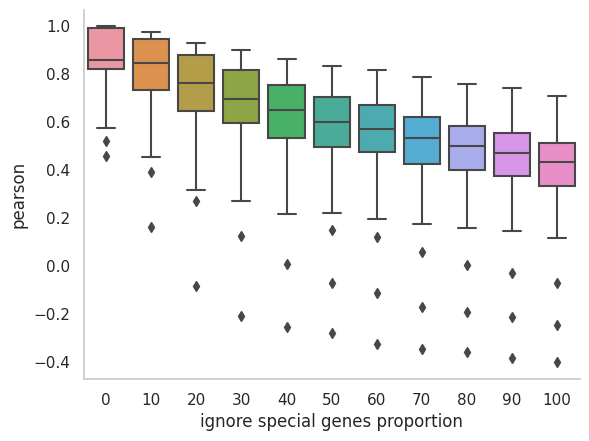

In [10]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

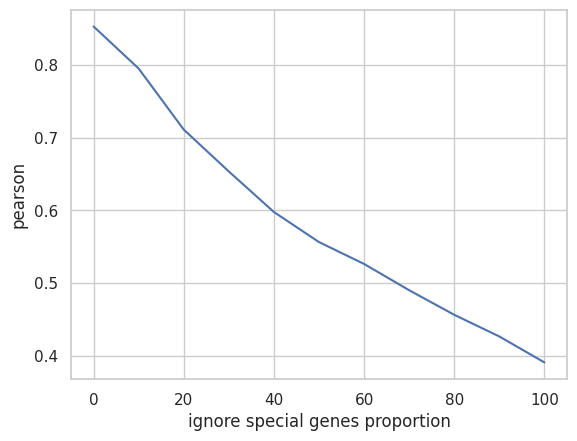

In [11]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [12]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/PDGFRA/model_epoch_9.pth', 'PDGFRA', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

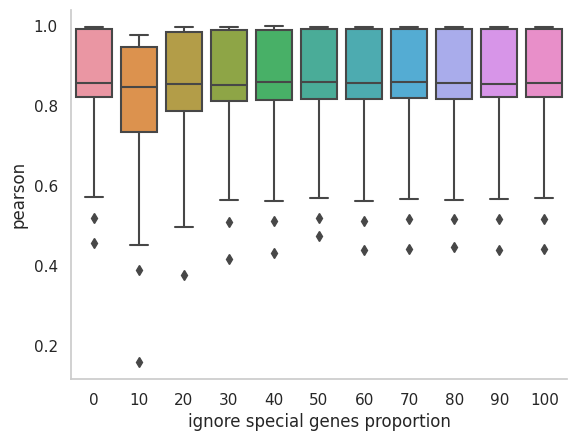

In [13]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

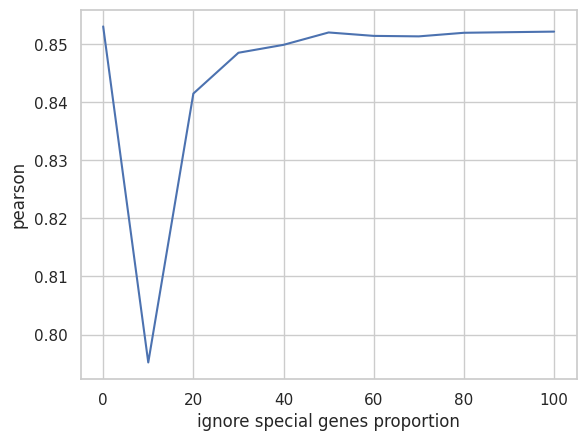

In [14]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

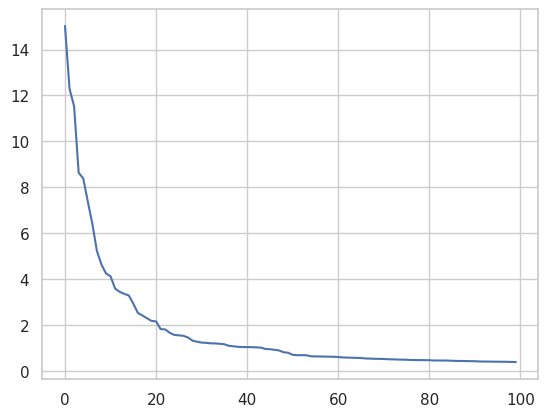

In [15]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)